In [1]:
!pip install kaggle


In [4]:
!mkdir -p ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c grasp-and-lift-eeg-detection
!unzip grasp-and-lift-eeg-detection.zip
!unzip train.zip
!unzip test.zip

100% 1.02G/1.02G [00:48<00:00, 33.0MB/s]
100% 1.02G/1.02G [00:48<00:00, 22.6MB/s]
Archive:  grasp-and-lift-eeg-detection.zip
  inflating: sample_submission.csv.zip  
  inflating: test.zip                
  inflating: train.zip               
Archive:  train.zip
   creating: train/
  inflating: train/subj10_series1_data.csv  
  inflating: train/subj10_series1_events.csv  
  inflating: train/subj10_series2_data.csv  
  inflating: train/subj10_series2_events.csv  
  inflating: train/subj10_series3_data.csv  
  inflating: train/subj10_series3_events.csv  
  inflating: train/subj10_series4_data.csv  
  inflating: train/subj10_series4_events.csv  
  inflating: train/subj10_series5_data.csv  
  inflating: train/subj10_series5_events.csv  
  inflating: train/subj10_series6_data.csv  
  inflating: train/subj10_series6_events.csv  
  inflating: train/subj10_series7_data.csv  
  inflating: train/subj10_series7_events.csv  
  inflating: train/subj10_series8_data.csv  
  inflating: train/subj10_ser

In [17]:
import os
import pandas as pd
from scipy.signal import butter, lfilter

# Define paths
data_dir = 'train/'
subject = 'subj1'
session_prefix = f'{subject}_series'
n_sessions = 8  # Replace with the actual number of sessions if different

# Define bandpass filter parameters
fs = 500  # Sampling frequency
lowcut = 1.0  # Low cut-off frequency
highcut = 32  # High cut-off frequency

# Define the bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Define the filtering function
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data, axis=0)
    return y

# Initialize empty DataFrames to hold all filtered EEG and event data
all_filtered_eeg_data = pd.DataFrame()
all_events_data = pd.DataFrame()

# Process each session
for session in range(1, n_sessions + 1):
    # Load data and events
    eeg_data = pd.read_csv(os.path.join(data_dir, f'{session_prefix}{session}_data.csv'))
    events = pd.read_csv(os.path.join(data_dir, f'{session_prefix}{session}_events.csv'))

    # Exclude the 'id' column for filtering
    eeg_signals = eeg_data.drop('id', axis=1)

    # Apply the bandpass filter
    filtered_signals = butter_bandpass_filter(eeg_signals.values, lowcut, highcut, fs, order=5)

    # Create a DataFrame with the filtered data
    filtered_eeg_data = pd.DataFrame(filtered_signals, columns=eeg_signals.columns)

    # Reinsert the 'id' column
    filtered_eeg_data.insert(0, 'id', eeg_data['id'])

    # Concatenate the filtered EEG data to the main EEG DataFrame
    all_filtered_eeg_data = pd.concat([all_filtered_eeg_data, filtered_eeg_data], ignore_index=True)

    # Concatenate the event data to the main events DataFrame
    all_events_data = pd.concat([all_events_data, events], ignore_index=True)

# Save or continue processing all_filtered_eeg_data and all_events_data
# all_filtered_eeg_data.to_csv('all_filtered_eeg_data.csv', index=False)
# all_events_data.to_csv('all_events_data.csv', index=False)


In [18]:
all_filtered_eeg_data.shape

(1422392, 33)

In [19]:
epochs = []
event_labels = []

# List of event columns in the events DataFrame
event_columns = ['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff', 'Replace', 'BothReleased']


In [20]:
import numpy as np
epochs = []
labels = []

# Define the sampling rate and epoch window in seconds
sampling_rate = 500  # Example: 500 Hz sampling rate
pre_event_time = 0.5  # 0.5 seconds before the event
post_event_time = 2  # 0.5 seconds after the event

# Convert time to samples
pre_event_samples = int(pre_event_time * sampling_rate)
post_event_samples = int(post_event_time * sampling_rate)
event_duration_samples = int(0.3 * sampling_rate)  # Duration of event in samples

for event_type in all_events_data.columns[1:]:  # Skip 'id' column
    event_series = all_events_data[event_type]

    # Find indices where the event starts and ends
    start_indices = event_series.index[event_series.diff() == 1].tolist()
    end_indices = event_series.index[event_series.diff() == -1].tolist()

    # Ensure that for every start, there is an end
    if end_indices[0] < start_indices[0]:
        end_indices.pop(0)
    if end_indices[-1] < start_indices[-1]:
        start_indices.pop()

    for start, end in zip(start_indices, end_indices):
        # Define the epoch start and end indices
        epoch_start = max(start - pre_event_samples, 0)
        epoch_end = min(end + post_event_samples, len(all_filtered_eeg_data))

        # Extract the epoch from the EEG data
        epoch = all_filtered_eeg_data.iloc[epoch_start:epoch_end].values

        # Store the epoch and corresponding label
        epochs.append(epoch)
        labels.append(event_type)

# Convert lists to numpy arrays
epochs_array = np.array(epochs, dtype=object)  # Use dtype=object due to variable epoch lengths
labels_array = np.array(labels)

print('Epochs shape:', epochs_array.shape)
print('Labels shape:', labels_array.shape)

Epochs shape: (1560, 1400, 33)
Labels shape: (1560,)


In [21]:
Epochs_array= epochs_array[:,:,1:]
print(labels_array[1])

HandStart


In [22]:
import numpy as np
from scipy.signal import butter, filtfilt, resample


# lowcut = 1.0
# highcut = 32.0

# def butter_bandpass(lowcut, highcut, fs, order=5):
#     nyq = 0.5 * fs
#     low = lowcut / nyq
#     high = highcut / nyq
#     b, a = butter(order, [low, high], btype='band')
#     return b, a

# def bandpass_filter(data, lowcut, highcut, fs, order=5):
#     b, a = butter_bandpass(lowcut, highcut, fs, order=order)
#     y = filtfilt(b, a, data, axis=0)
#     return y


# filtered_epochs = [bandpass_filter(epoch, lowcut, highcut, sampling_rate) for epoch in Epochs_array]


new_sampling_rate = 250


resampled_epochs = [resample(epoch, int(epoch.shape[0] * new_sampling_rate / sampling_rate), axis=0) for epoch in Epochs_array]


baseline_corrected_epochs = []
for epoch in resampled_epochs:
    baseline = np.mean(epoch[:pre_event_samples], axis=0)
    corrected_epoch = epoch - baseline
    baseline_corrected_epochs.append(corrected_epoch)




In [25]:
baseline_corrected_epochs = np.array(baseline_corrected_epochs)
from sklearn.preprocessing import LabelEncoder
x =baseline_corrected_epochs.transpose(0,2,1)
y = labels_array
# Encode labels to integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [26]:
print(np.shape(x),np.shape(y))

(1560, 32, 700) (1560,)


In [32]:

def compute_csp(data, labels, num_filters_per_class=2):
    num_classes = len(np.unique(labels))
    filters_per_class = num_filters_per_class
    total_filters = filters_per_class * num_classes

    # Initialize an array to store the filters
    filters = np.zeros((data.shape[2], total_filters))

    for class_label in range(num_classes):
        # Separate data by class
        class_data = data[labels == class_label]

        # Compute average covariance matrix for the class
        cov_class = np.mean([np.cov(epoch, rowvar=False) for epoch in class_data], axis=0)

        # Eigenvalue decomposition for whitening matrix
        eigvals, eigvecs = np.linalg.eigh(cov_class)
        # Avoid division by zero
        eigvals[eigvals < 0] = 0
        D = np.diag(1.0 / np.sqrt(eigvals))
        whitening_matrix = np.dot(eigvecs, np.dot(D, eigvecs.T))

        # Transform the covariance matrix
        S_class = np.dot(whitening_matrix, np.dot(cov_class, whitening_matrix.T))

        # Eigenvalue decomposition of transformed matrix
        eigvals_class, eigvecs_class = np.linalg.eigh(S_class)

        # Select filters for the class
        selected_filters = eigvecs_class[:, :filters_per_class]

        # Reshape the selected filters and assign to the appropriate columns
        selected_filters = selected_filters.T.reshape(-1)
        filters[:, class_label * filters_per_class : (class_label + 1) * filters_per_class] = selected_filters

    return filters

def apply_csp(data, filters):
    # data shape: (epochs, channels, time)
    # filters shape: (channels, total_filters)
    return np.array([np.dot(epoch.T, filters) for epoch in data])

# Example usage:
# filters = compute_csp(data, labels)
# X_csp = apply_csp(data, filters)

# Example usage:
# filters = compute_csp(data, labels)
# X_csp = apply_csp(data, filters)


# Example usage:
filters = compute_csp(x,y)
# X_csp = apply_csp(x, filters)


ValueError: ignored

In [34]:


def compute_csp(data, labels, num_filters_per_class=2):
    num_epochs, num_channels, num_samples = data.shape
    num_classes = len(np.unique(labels))
    num_filters = num_classes * num_filters_per_class

    # Initialize the filters matrix
    filters = np.zeros((num_channels, num_filters))

    for class_label in range(num_classes):
        # Separate data for the current class
        class_data = data[labels == class_label]

        # Compute average covariance matrix for the current class
        cov_matrix = np.mean([np.cov(epoch) for epoch in class_data], axis=0)

        # Eigenvalue decomposition for whitening matrix
        eigvals, eigvecs = np.linalg.eigh(cov_matrix)
        eigvals[eigvals < 0] = 0  # Avoid division by zero
        D = np.diag(1.0 / np.sqrt(eigvals))
        whitening_matrix = np.dot(eigvecs, np.dot(D, eigvecs.T))

        # Transform the covariance matrix
        S = np.dot(whitening_matrix, np.dot(cov_matrix, whitening_matrix.T))

        # Eigenvalue decomposition of transformed matrix
        eigvals, eigvecs = np.linalg.eigh(S)

        # Select CSP filters for the current class
        selected_filters = eigvecs[:, :num_filters_per_class]

        # Assign selected filters to the appropriate columns
        filters[:, class_label * num_filters_per_class : (class_label + 1) * num_filters_per_class] = selected_filters

        # Print the shape after selecting CSP filters for the current class
        print(f'Shape after selecting CSP filters for class {class_label}: {selected_filters.shape}')

    # Print the final shape of the filters matrix
    print(f'Final shape of filters: {filters.shape}')

    return filters

# Example usage:
# Assuming data and labels are defined with shape (num_epochs, num_channels, num_samples)
filters = compute_csp(x,y)


Shape after selecting CSP filters for class 0: (32, 2)
Shape after selecting CSP filters for class 1: (32, 2)
Shape after selecting CSP filters for class 2: (32, 2)
Shape after selecting CSP filters for class 3: (32, 2)
Shape after selecting CSP filters for class 4: (32, 2)
Shape after selecting CSP filters for class 5: (32, 2)
Final shape of filters: (32, 12)


In [ ]:
import matplotlib.pyplot as plt

# Replace these with your actual data for a single epoch
cwt_data = X_cwt[0]
rgb_image1 = rgb_images[0]
rgb_image2 = rgb_images[1]

# Create subplots for CWT features
fig, axs_cwt = plt.subplots(2, 3, figsize=(12, 8))

# Plot CWT features
for i in range(6):
    row = i // 3
    col = i % 3
    axs_cwt[row, col].imshow(cwt_data[i], cmap='viridis', aspect='auto')
    axs_cwt[row, col].set_title(f'CWT Feature {i + 1}')
    axs_cwt[row, col].axis('off')

# Create subplots for RGB images
fig, axs_rgb = plt.subplots(1, 2, figsize=(12, 4))

# Plot RGB images
axs_rgb[0].imshow(np.transpose(rgb_image1, (1, 2, 0)))
axs_rgb[0].set_title('RGB Image 1')
axs_rgb[0].axis('off')

axs_rgb[1].imshow(np.transpose(rgb_image2, (1, 2, 0)))
axs_rgb[1].set_title('RGB Image 2')
axs_rgb[1].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [35]:
def apply_csp(data, filters):
    # data shape: (epochs, channels, time)
    # filters shape: (channels, total_filters)
    return np.array([np.dot(epoch.T, filters) for epoch in data])

X_csp = apply_csp(x, filters)

In [37]:
import pywt
def compute_cwt(data, scales, wavelet_name='cmor'):
    # Applying CWT using PyWavelets
    coefficients, frequencies = pywt.cwt(data, scales, wavelet_name, axis=-1)
    return np.abs(coefficients)
def apply_cwt(data, scales):
    # Apply CWT to each epoch and CSP component
    return np.array([compute_cwt(epoch, scales) for epoch in data])
scales = np.arange(1, 31)  # example scales

# Apply CWT
X_cwt = apply_cwt(X_csp, scales)
X_cwt = np.transpose(X_cwt, (0, 3, 1, 2))


/usr/local/lib/python3.10/dist-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


In [41]:
print(x.shape)
X_cwt.shape

(1560, 32, 700)


(1560, 12, 30, 700)

In [42]:
import numpy as np
import cv2
import torch
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

# Assuming cwt_data has shape (num_epochs, num_channels, H, W)
# and labels is an array of shape (num_epochs,) with class labels (0 to 5)

cwt_data = X_cwt
labels = y

# Resizing the scalograms to 224x224 using cubic interpolation
resized_scalograms = np.empty((cwt_data.shape[0], cwt_data.shape[1], 224, 224))
for i in range(cwt_data.shape[0]):
    for j in range(cwt_data.shape[1]):
        resized_scalograms[i, j] = cv2.resize(cwt_data[i, j], (224, 224), interpolation=cv2.INTER_CUBIC)


rgb_images_sets = []
for i in range(4):
    rgb_images_sets.append(resized_scalograms[:, i * 3 : (i + 1) * 3])

# Duplicate the labels for each set of RGB images
labels = np.concatenate((labels, labels, labels, labels))

# Combine all sets to form a single dataset
rgb_images = np.vstack(rgb_images_sets)
tensor_x = torch.Tensor(rgb_images)
tensor_y = torch.Tensor(labels)

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Compose, Normalize, ToTensor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



In [46]:


# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(tensor_x, tensor_y, test_size=0.2, random_state=42)

# Create data loaders
batch_size = 20
train_dataset = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_dataset = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

# Load pre-trained MobileNetV2 and modify the classifier
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 6)  # Assuming binary classification

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialize lists to monitor loss and accuracy as the model trains
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Number of epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_dataset:
        images, labels = images.to(device, dtype=torch.float), labels.to(device, dtype=torch.long)  # Ensure labels are Long


        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_dataset))
    train_accuracies.append(100 * correct / total)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_dataset:
            images, labels = images.to(device, dtype=torch.float), labels.to(device, dtype=torch.long)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_losses.append(running_loss / len(test_dataset))
    test_accuracies.append(100 * correct / total)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, '
          f'Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%')


Epoch [1/10], Train Loss: 1.4038, Train Accuracy: 40.28%, Test Loss: 1.1723, Test Accuracy: 48.32%
Epoch [2/10], Train Loss: 1.0605, Train Accuracy: 54.77%, Test Loss: 0.9374, Test Accuracy: 57.77%
Epoch [3/10], Train Loss: 0.8728, Train Accuracy: 62.52%, Test Loss: 0.8706, Test Accuracy: 61.86%
Epoch [4/10], Train Loss: 0.7051, Train Accuracy: 70.09%, Test Loss: 0.7034, Test Accuracy: 70.19%
Epoch [5/10], Train Loss: 0.5798, Train Accuracy: 76.18%, Test Loss: 0.7016, Test Accuracy: 73.00%
Epoch [6/10], Train Loss: 0.4595, Train Accuracy: 82.87%, Test Loss: 0.4326, Test Accuracy: 82.21%
Epoch [7/10], Train Loss: 0.3766, Train Accuracy: 86.12%, Test Loss: 0.5509, Test Accuracy: 79.73%
Epoch [8/10], Train Loss: 0.2935, Train Accuracy: 89.00%, Test Loss: 0.3678, Test Accuracy: 85.98%
Epoch [9/10], Train Loss: 0.2540, Train Accuracy: 91.03%, Test Loss: 0.5057, Test Accuracy: 84.29%
Epoch [10/10], Train Loss: 0.2050, Train Accuracy: 93.05%, Test Loss: 0.3099, Test Accuracy: 89.34%


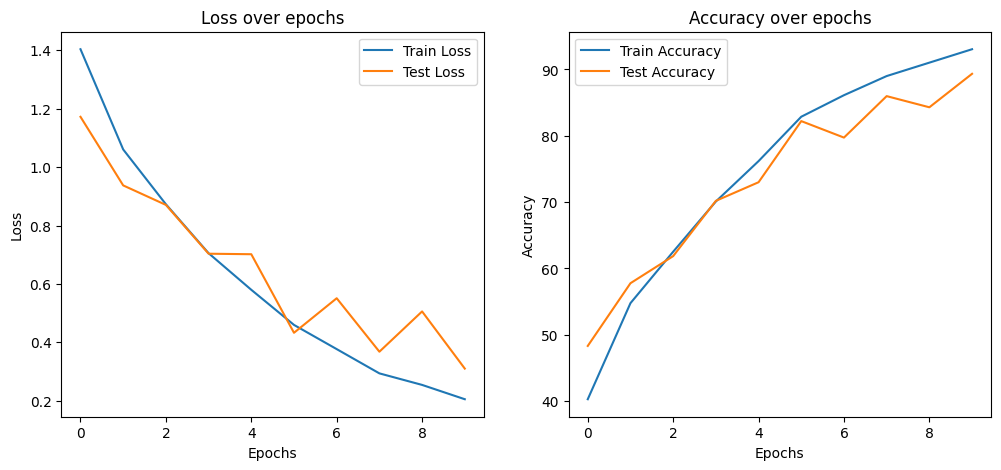

In [48]:

# Plot training and test loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(num_epochs), test_accuracies, label='Test Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Accuracy: 89.34%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.86      0.89       220
         1.0       0.85      0.86      0.86       203
         2.0       0.91      0.88      0.90       198
         3.0       0.99      0.86      0.92       219
         4.0       0.84      0.93      0.88       180
         5.0       0.86      0.96      0.91       228

    accuracy                           0.89      1248
   macro avg       0.90      0.89      0.89      1248
weighted avg       0.90      0.89      0.89      1248

Class 0 - ROC AUC Score: 0.99
Class 1 - ROC AUC Score: 0.99
Class 2 - ROC AUC Score: 0.99
Class 3 - ROC AUC Score: 0.99
Class 4 - ROC AUC Score: 0.99
Class 5 - ROC AUC Score: 0.99


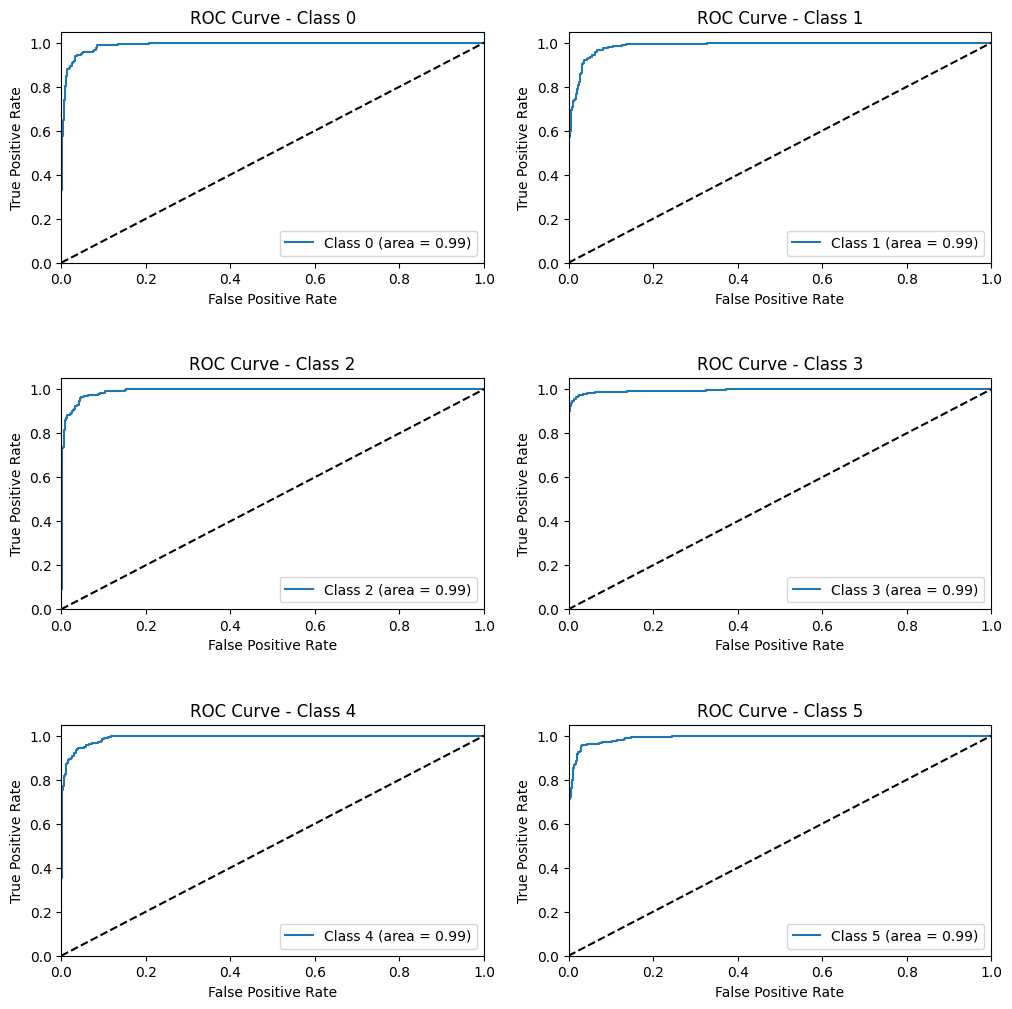

In [51]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Place the model in evaluation mode
model.eval()

# Lists to store true labels, predictions, and probabilities
true_labels = []
predictions = []
probabilities = []

with torch.no_grad():
    for images, labels in test_dataset:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)

        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())
        probs = torch.nn.functional.softmax(outputs, dim=1)
        probabilities.extend(probs.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Classification report
print('Classification Report:')
print(classification_report(true_labels, predictions))

# Create subplots in a (3, 2) grid
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5)

# Plot ROC AUC curve for each class
n_classes = len(np.unique(true_labels))
plot_idx = 0
for class_idx in range(n_classes):
    binary_true_labels = [1 if label == class_idx else 0 for label in true_labels]
    class_probs = [prob[class_idx] for prob in probabilities]

    auc_score = roc_auc_score(binary_true_labels, class_probs)
    print(f'Class {class_idx} - ROC AUC Score: {auc_score:.2f}')

    fpr, tpr, _ = roc_curve(binary_true_labels, class_probs)

    row_idx, col_idx = divmod(plot_idx, 2)
    axs[row_idx, col_idx].plot(fpr, tpr, label=f'Class {class_idx} (area = {auc_score:.2f})')
    axs[row_idx, col_idx].plot([0, 1], [0, 1], 'k--')
    axs[row_idx, col_idx].set_xlim([0.0, 1.0])
    axs[row_idx, col_idx].set_ylim([0.0, 1.05])
    axs[row_idx, col_idx].set_xlabel('False Positive Rate')
    axs[row_idx, col_idx].set_ylabel('True Positive Rate')
    axs[row_idx, col_idx].set_title(f'ROC Curve - Class {class_idx}')
    axs[row_idx, col_idx].legend(loc="lower right")

    plot_idx += 1

plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Place the model in evaluation mode
model.eval()

# Lists to store true labels, predictions, and probabilities
true_labels = []
predictions = []
probabilities = []

with torch.no_grad():
    for images, labels in test_dataset:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)

        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())
        probs = torch.nn.functional.softmax(outputs, dim=1)
        probabilities.extend(probs.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Classification report
print('Classification Report:')
print(classification_report(true_labels, predictions))

# Create subplots in a (3, 2) grid
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5)

# Plot ROC AUC curve for each class
n_classes = len(np.unique(true_labels))
plot_idx = 0
for class_idx in range(n_classes):
    binary_true_labels = [1 if label == class_idx else 0 for label in true_labels]
    class_probs = [prob[class_idx] for prob in probabilities]

    auc_score = roc_auc_score(binary_true_labels, class_probs)
    print(f'Class {class_idx} - ROC AUC Score: {auc_score:.2f}')

    fpr, tpr, _ = roc_curve(binary_true_labels, class_probs)

    row_idx, col_idx = divmod(plot_idx, 2)
    axs[row_idx, col_idx].plot(fpr, tpr, label=f'Class {class_idx} (area = {auc_score:.2f})')
    axs[row_idx, col_idx].plot([0, 1], [0, 1], 'k--')
    axs[row_idx, col_idx].set_xlim([0.0, 1.0])
    axs[row_idx, col_idx].set_ylim([0.0, 1.05])
    axs[row_idx, col_idx].set_xlabel('False Positive Rate')
    axs[row_idx, col_idx].set_ylabel('True Positive Rate')
    axs[row_idx, col_idx].set_title(f'ROC Curve - Class {class_idx}')
    axs[row_idx, col_idx].legend(loc="lower right")

    plot_idx += 1

plt.show()


Accuracy: 89.34%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.86      0.89       220
         1.0       0.85      0.86      0.86       203
         2.0       0.91      0.88      0.90       198
         3.0       0.99      0.86      0.92       219
         4.0       0.84      0.93      0.88       180
         5.0       0.86      0.96      0.91       228

    accuracy                           0.89      1248
   macro avg       0.90      0.89      0.89      1248
weighted avg       0.90      0.89      0.89      1248

Class 0 - ROC AUC Score: 0.99
Class 1 - ROC AUC Score: 0.99
Class 2 - ROC AUC Score: 0.99
Class 3 - ROC AUC Score: 0.99
Class 4 - ROC AUC Score: 0.99
Class 5 - ROC AUC Score: 0.99


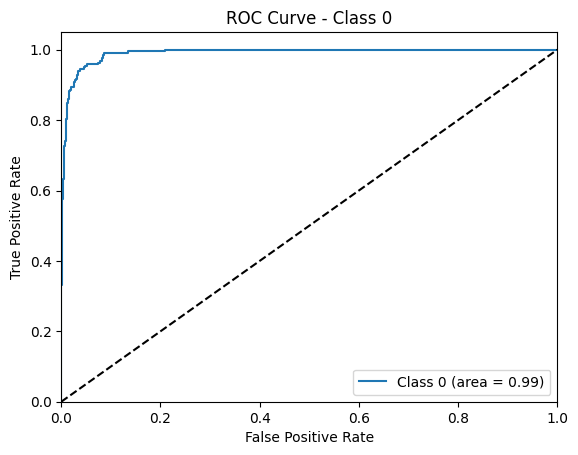

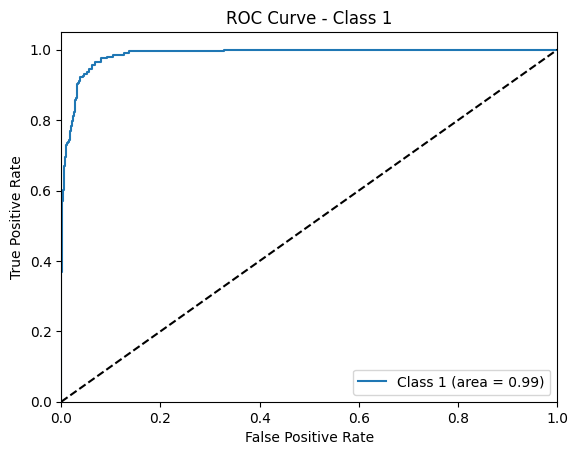

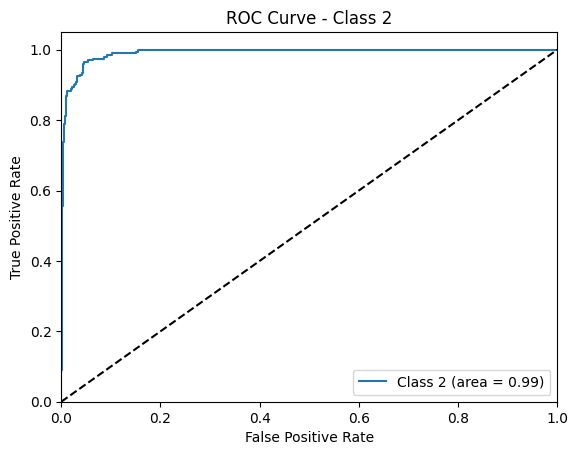

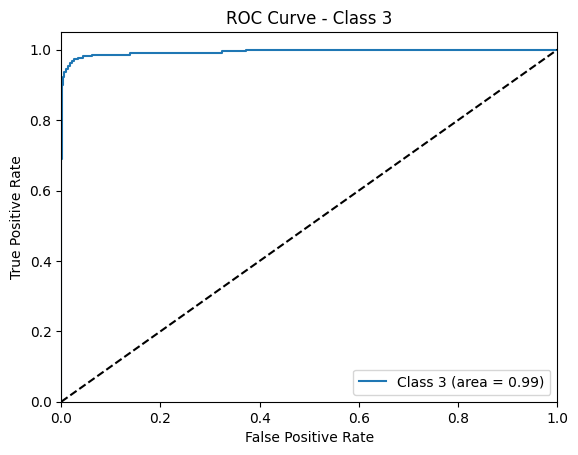

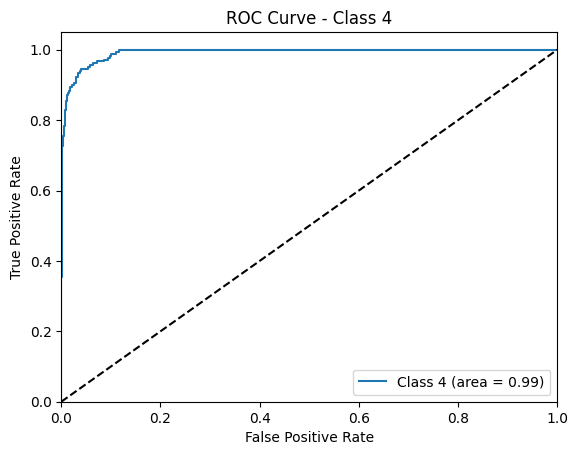

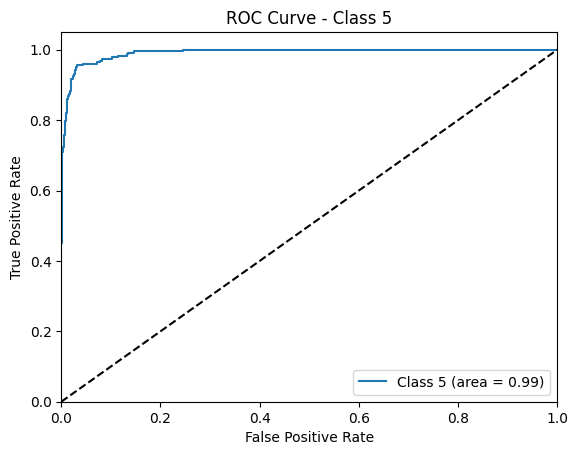

In [52]:
from torch.optim import lr_scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.005)
# Initialize variables to keep track of the best model
best_accuracy = 0.0
best_model_state_dict = None
num_epochs = 20
# Training loop with lr_scheduler and model saving
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_dataset:
        images, labels = images.to(device, dtype=torch.float), labels.to(device, dtype=torch.long)  # Ensure labels are Long

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_dataset))
    train_accuracies.append(100 * correct / total)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_dataset:
            images, labels = images.to(device, dtype=torch.float), labels.to(device, dtype=torch.long)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_losses.append(running_loss / len(test_dataset))
        test_accuracies.append(100 * correct / total)

        # Step the learning rate scheduler
        scheduler.step()

        # Check if this is the best model so far
        if test_accuracies[-1] > best_accuracy:
            best_accuracy = test_accuracies[-1]
            best_model_state_dict = model.state_dict()

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, '
              f'Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%')

# Save the best model
if best_model_state_dict is not None:
    torch.save(best_model_state_dict, 'best_model.pth')

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch [1/20], Train Loss: 1.3592, Train Accuracy: 44.97%, Test Loss: 1.2867, Test Accuracy: 48.24%
Epoch [2/20], Train Loss: 1.1690, Train Accuracy: 51.78%, Test Loss: 1.1111, Test Accuracy: 51.92%
Epoch [3/20], Train Loss: 1.0684, Train Accuracy: 55.61%, Test Loss: 1.1741, Test Accuracy: 54.81%
Epoch [4/20], Train Loss: 1.0163, Train Accuracy: 57.99%, Test Loss: 1.1391, Test Accuracy: 52.48%
Epoch [5/20], Train Loss: 1.0033, Train Accuracy: 59.31%, Test Loss: 1.3949, Test Accuracy: 43.59%
Epoch [6/20], Train Loss: 0.9669, Train Accuracy: 59.64%, Test Loss: 0.9905, Test Accuracy: 58.81%
Epoch [7/20], Train Loss: 1.0501, Train Accuracy: 57.03%, Test Loss: 0.9529, Test Accuracy: 60.82%
Epoch [8/20], Train Loss: 0.8898, Train Accuracy: 63.50%, Test Loss: 0.9371, Test Accuracy: 62.50%
Epoch [9/20], Train Loss: 0.8259, Train Accuracy: 66.11%, Test Loss: 2.1765, Test Accuracy: 31.33%
Epoch [10/20], Train Loss: 1.2670, Train Accuracy: 49.08%, Test Loss: 1.0161, Test Accuracy: 58.17%
Epoch [11

In [ ]:
best_model.load_state_dict(torch.load('Best_model.pth'))  # Load the trained weights
best_model = best_model.to(device)  # Move the model to the device (CPU or GPU)

# Set the model in evaluation mode
best_model.eval()

# Lists to store true labels, predictions, and probabilities
true_labels = []
predictions = []
probabilities = []

with torch.no_grad():
    for images, labels in test_dataset:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)

        _, predicted = torch.max(outputs.data, 1)

        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())
        probs = torch.nn.functional.softmax(outputs, dim=1)
        probabilities.extend(probs.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Classification report
print('Classification Report:')
print(classification_report(true_labels, predictions))

# Create subplots in a (3, 2) grid
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5)

# Plot ROC AUC curve for each class
n_classes = len(np.unique(true_labels))
plot_idx = 0
for class_idx in range(n_classes):
    binary_true_labels = [1 if label == class_idx else 0 for label in true_labels]
    class_probs = [prob[class_idx] for prob in probabilities]

    auc_score = roc_auc_score(binary_true_labels, class_probs)
    print(f'Class {class_idx} - ROC AUC Score: {auc_score:.2f}')

    fpr, tpr, _ = roc_curve(binary_true_labels, class_probs)

    row_idx, col_idx = divmod(plot_idx, 2)
    axs[row_idx, col_idx].plot(fpr, tpr, label=f'Class {class_idx} (area = {auc_score:.2f})')
    axs[row_idx, col_idx].plot([0, 1], [0, 1], 'k--')
    axs[row_idx, col_idx].set_xlim([0.0, 1.0])
    axs[row_idx, col_idx].set_ylim([0.0, 1.05])
    axs[row_idx, col_idx].set_xlabel('False Positive Rate')
    axs[row_idx, col_idx].set_ylabel('True Positive Rate')
    axs[row_idx, col_idx].set_title(f'ROC Curve - Class {class_idx}')
    axs[row_idx, col_idx].legend(loc="lower right")

    plot_idx += 1

plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Accuracy: 69.31%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.58      0.64       220
         1.0       0.57      0.70      0.63       203
         2.0       0.72      0.56      0.63       198
         3.0       0.87      0.86      0.86       219
         4.0       0.69      0.74      0.71       180
         5.0       0.62      0.71      0.67       228

    accuracy                           0.69      1248
   macro avg       0.70      0.69      0.69      1248
weighted avg       0.70      0.69      0.69      1248

Class 0 - ROC AUC Score: 0.93
Class 1 - ROC AUC Score: 0.92
Class 2 - ROC AUC Score: 0.93
Class 3 - ROC AUC Score: 0.98
Class 4 - ROC AUC Score: 0.95
Class 5 - ROC AUC Score: 0.92


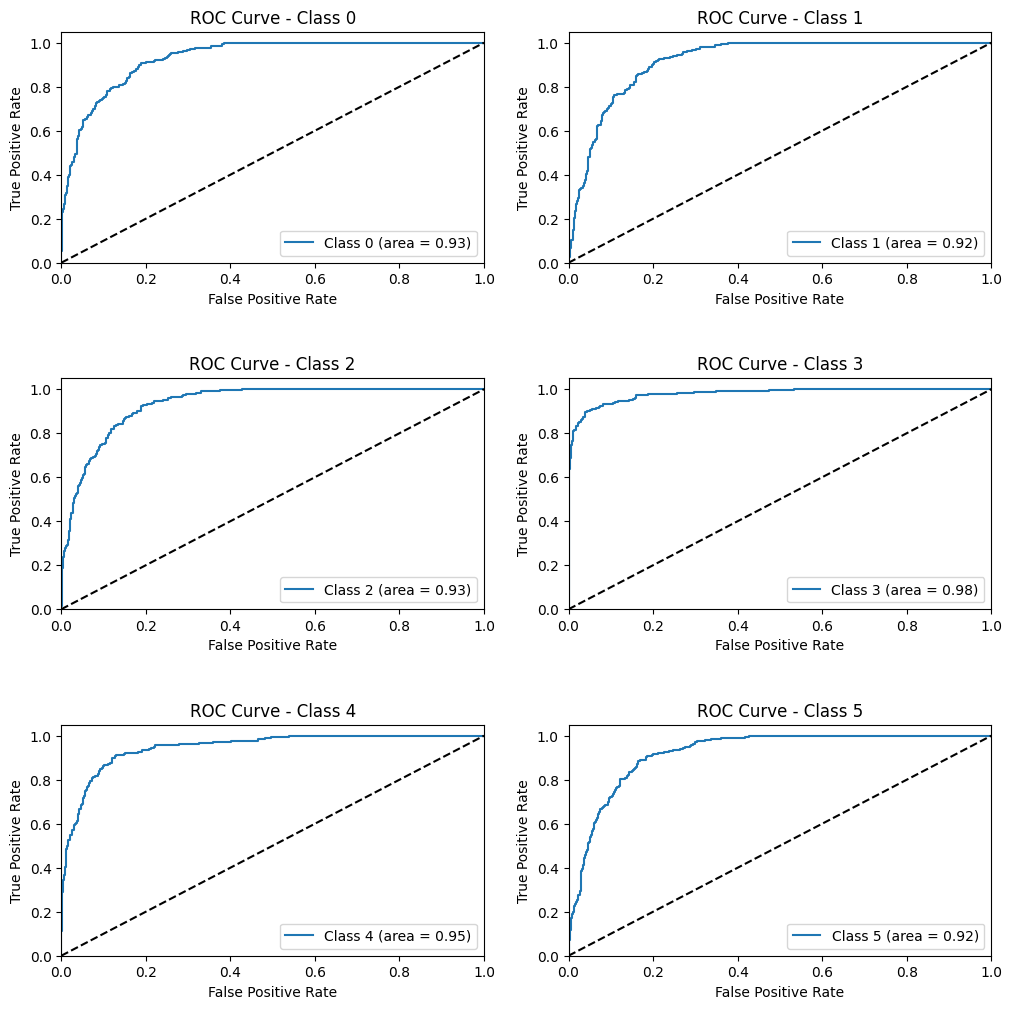

In [54]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import mobilenet_v2

# Create a MobileNetV2 model with the same architecture as the trained model
model = mobilenet_v2(pretrained=False)

model.classifier[1] = nn.Linear(model.last_channel, 6)

# Load the trained weights into the model
model.load_state_dict(torch.load('best_model.pth'))

# Prepare the model for quantization
model = model.to('cpu')  # Move the model to the CPU (quantization doesn't work well on GPU)

# Lists to store true labels, predictions, and probabilities
true_labels = []
predictions = []
probabilities = []

with torch.no_grad():
    for images, labels in test_dataset:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)

        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())
        probs = torch.nn.functional.softmax(outputs, dim=1)
        probabilities.extend(probs.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Classification report
print('Classification Report:')
print(classification_report(true_labels, predictions))

# Create subplots in a (3, 2) grid
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5)

# Plot ROC AUC curve for each class
n_classes = len(np.unique(true_labels))
plot_idx = 0
for class_idx in range(n_classes):
    binary_true_labels = [1 if label == class_idx else 0 for label in true_labels]
    class_probs = [prob[class_idx] for prob in probabilities]

    auc_score = roc_auc_score(binary_true_labels, class_probs)
    print(f'Class {class_idx} - ROC AUC Score: {auc_score:.2f}')

    fpr, tpr, _ = roc_curve(binary_true_labels, class_probs)

    row_idx, col_idx = divmod(plot_idx, 2)
    axs[row_idx, col_idx].plot(fpr, tpr, label=f'Class {class_idx} (area = {auc_score:.2f})')
    axs[row_idx, col_idx].plot([0, 1], [0, 1], 'k--')
    axs[row_idx, col_idx].set_xlim([0.0, 1.0])
    axs[row_idx, col_idx].set_ylim([0.0, 1.05])
    axs[row_idx, col_idx].set_xlabel('False Positive Rate')
    axs[row_idx, col_idx].set_ylabel('True Positive Rate')
    axs[row_idx, col_idx].set_title(f'ROC Curve - Class {class_idx}')
    axs[row_idx, col_idx].legend(loc="lower right")

    plot_idx += 1

plt.show()


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import pandas as pd



def plot_epoch(epoch_idx):
    epoch_data = resampled_epochs[epoch_idx]
    # epoch_data = baseline_corrected_epochs[epoch_idx]
    label = labels_array[epoch_idx]
    num_channels = epoch_data.shape[1]

    # Create subplots with shared x-axis (time)
    fig, axs = plt.subplots(num_channels, 1, figsize=(15, num_channels*2), sharex=True)

    # Time vector for x-axis
    time = np.arange(epoch_data.shape[0]) / sampling_rate

    for i in range(num_channels):
        # Offset for better visibility
        offset = i * epoch_data.max()

        # Plot the data for each channel with an offset
        axs[i].plot(time, epoch_data[:, i] + offset)
        axs[i].set_ylabel('Ch ' + str(i))

        # Remove y-ticks to enhance clarity, adjust as needed
        axs[i].set_yticks([])

        # Set the title for the first subplot
        if i == 0:
            axs[i].set_title(f'Epoch {epoch_idx} - Label: {label}')

    # Set common labels
    plt.xlabel('Time (s)')
    plt.show()

# Create an interactive widget to scroll through epochs
interact(plot_epoch, epoch_idx=IntSlider(min=0, max=len(epochs_array)-1, step=1, value=0))


interactive(children=(IntSlider(value=0, description='epoch_idx', max=1559), Output()), _dom_classes=('widget-…

<function __main__.plot_epoch(epoch_idx)>

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
unique_classes = np.unique(labels_array)
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=labels_array)
class_weight_dict = {label: weight for label, weight in zip(unique_classes, class_weights)}

X_train, X_test, y_train, y_test = train_test_split(baseline_corrected_epochs, labels_array, test_size=0.2, stratify=labels_array)

In [ ]:
!pip install -q mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 44.7 MB/s eta 0:00:00


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
X_train_csp = X_train_csp.reshape(X_train_csp.shape[0], -1)

xgb.fit(X_train_csp, y_train_encoded)
X_test_csp = X_test_csp.reshape(X_test_csp.shape[0], -1)

predictions_encoded = xgb.predict(X_test_csp)
predictions = label_encoder.inverse_transform(predictions_encoded)

print(classification_report(y_test_encoded, predictions_encoded))

              precision    recall  f1-score   support

           0       0.49      0.40      0.44        52
           1       0.27      0.33      0.30        52
           2       0.27      0.33      0.30        52
           3       0.74      0.60      0.66        52
           4       0.20      0.19      0.20        52
           5       0.48      0.50      0.49        52

    accuracy                           0.39       312
   macro avg       0.41      0.39      0.40       312
weighted avg       0.41      0.39      0.40       312



In [ ]:

from xgboost import XGBClassifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')


In [ ]:
csp = CSP(n_components=6, reg=None, log=None, norm_trace=False, transform_into='csp_space', cov_est='epoch')
xgb = XGBClassifier()

# Apply CSP to the training data
csp.fit(X_train, y_train_encoded)
X_train_csp = csp.transform(X_train)

# Apply the same CSP transformation to the test data
X_test_csp = csp.transform(X_test)

Streaming output truncated to the last 5000 lines.
Computing rank from data with rank=None
    Using tolerance 28 (2.2e-16 eps * 32 dim * 4e+15  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 256 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 256 -> 32
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 35 (2.2e-16 eps * 32 dim * 4.9e+15  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 256 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 256 -> 32
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 33 (2.2e-16 eps * 32 dim * 4.7e+15  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 256 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (with